# 1. Import libraries and set the data path  
Here we load the main Python libraries and point to the folder that contains all raw text files.  
Nothing fancy, just basic setup.


In [41]:
from pathlib import Path  # dosya/klasör yolları için

import pandas as pd       # tablo yapısı ve veri işleme
import numpy as np        # numerik işlemler (özellikle coef analizinde)
from sklearn.model_selection import train_test_split  # train/test ayırma
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF özellik çıkarımı
from sklearn.linear_model import LogisticRegression  # çok sınıflı lineer model
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt  # grafik çizimi
import seaborn as sns            # daha rahat heatmap için
import re                        # regex ile text temizleme

# Notebook: nlp_midterm_author/notebooks/
# Data:     nlp_midterm_author/data/raw_texts/
DATA_DIR = Path("../data/raw_texts")

print("DATA_DIR:", DATA_DIR.resolve())
print("Exists:", DATA_DIR.exists())


DATA_DIR: C:\Users\Onat\Desktop\School\Classes\NLP\nlp_author_detection\data\raw_texts
Exists: True


# 2. Load all text files into a pandas dataframe  
Each folder inside `raw_texts` represents one author.  
We loop through folders, read text files, and store everything in a clean table.


In [42]:
rows = []  # (author_id, text) ciftlerini toplayacağız

# data/raw_texts içindeki klasorler : 1, 2, 3, ... her biri bir yazarı temsil ediyor
for author_folder in sorted(DATA_DIR.iterdir(), key=lambda p: int(p.name)):
    author_id = int(author_folder.name)  # klasör ismini integer yazar id olarak kullanıyoruz

    for txt_file in author_folder.glob("*.txt"):  # sadece .txt dosyalarını al
        text = txt_file.read_text(encoding="utf-8", errors="ignore").strip()
        if not text:
            continue  # boş dosyalari atliyoruz

        rows.append((author_id, text))

# rows listesini pandas dataframe'e ceviriyoruz
df = pd.DataFrame(rows, columns=["author_id", "text"])
df.head()


,author_id,text
0,1,THERE can be no doubt that Edinburgh is a huge...
1,1,WELL I can't say I'm sorry to see the back of ...
2,1,IT'S that time of year again when the Scottish...
3,1,IT was this time last year in the run up to th...
4,1,WHAT a joy to see the Scottish medal winners o...


# 3. Quick dataset overview  
Just checking the size of the dataset and how many samples each author has.  
Basic sanity check before moving on.


In [43]:
print("Total samples:", len(df))                          # toplam satir sayisi
print("Number of authors:", df["author_id"].nunique())   # farklı yazar satisi

# Her yazarın metin sayisi
df["author_id"].value_counts().sort_index()


Total samples: 1500
Number of authors: 30


author_id
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
11    50
12    50
13    50
14    50
15    50
16    50
17    50
18    50
19    50
20    50
21    50
22    50
23    50
24    50
25    50
26    50
27    50
28    50
29    50
30    50
Name: count, dtype: int64

4. Text length statistics  
Not required, but it's a simple way to understand how long the texts are.  
Longer texts often help classification.


In [44]:
# Metinde kaç kelime olduğunu olcuyoruz
df["text_length"] = df["text"].str.split().apply(len)

# Temel istatistikleri burada yazdiriyoruz
df["text_length"].describe()


count    1500.000000
mean      727.874000
std       319.649307
min       129.000000
25%       491.750000
50%       751.000000
75%       876.250000
max      2250.000000
Name: text_length, dtype: float64

# 5. Clean the text  
Lowercase, remove punctuation, and reduce multiple spaces.  
Very basic cleaning, but enough for TF-IDF based models.


In [45]:
def clean(t: str) -> str:
    t = t.lower()                          
    t = re.sub(r"[^a-z\s]", " ", t)        
    t = re.sub(r"\s+", " ", t)             
    return t.strip()                      

# temizlenmis text kolonu uretiyoruz (clean_text)
df["clean_text"] = df["text"].apply(clean)

df[["author_id", "clean_text"]].head()


,author_id,clean_text
0,1,there can be no doubt that edinburgh is a huge...
1,1,well i can t say i m sorry to see the back of ...
2,1,it s that time of year again when the scottish...
3,1,it was this time last year in the run up to th...
4,1,what a joy to see the scottish medal winners o...


# 6. Train/Test split + Word-level TF-IDF + Logistic Regression  
This is the core of the project.  
We convert text into TF-IDF vectors (unigrams + bigrams) and train a simple classifier.


In [46]:
# Test ve egitim datalarini ayiriyoruz
# %20 test %80 egitim datasi olucak
# stratify parametresine author_id vererek egitim datasinin daha tutarli olmasini sagliyoruz
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"],
    df["author_id"],
    test_size=0.2,
    random_state=42,
    stratify=df["author_id"], 
)

# Kelime bazlı TF-IDF (unigram + bigram)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Train verisine göre TF-IDF
X_train_vec = vectorizer.fit_transform(X_train)

# Test setini aynı vektörizer ile dönüştür 
X_test_vec = vectorizer.transform(X_test)

# Çok sınıflı logistic regression 
model = LogisticRegression(max_iter=2000)
model.fit(X_train_vec, y_train)

# Test setinde tahmin
y_pred = model.predict(X_test_vec)

# Sınıf bazlı precision, recall, f1 ve overall accuracy raporu
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      0.50      0.67        10
           2       0.71      1.00      0.83        10
           3       0.89      0.80      0.84        10
           4       0.88      0.70      0.78        10
           5       0.75      0.90      0.82        10
           6       1.00      0.70      0.82        10
           7       1.00      0.20      0.33        10
           8       0.80      0.80      0.80        10
           9       0.71      1.00      0.83        10
          10       0.56      1.00      0.71        10
          11       0.86      0.60      0.71        10
          12       0.67      1.00      0.80        10
          13       0.62      1.00      0.77        10
          14       1.00      0.60      0.75        10
          15       0.83      0.50      0.62        10
          16       0.80      0.80      0.80        10
          17       0.91      1.00      0.95        10
          18       0.86    

# 7. Accuracy and Macro F1  
Just printing the main scores separately.  
Makes the results easier to mention in the report.


In [47]:
acc = accuracy_score(y_test, y_pred)                 
macro_f1 = f1_score(y_test, y_pred, average="macro") 

print(f"Accuracy: {acc:.3f}")
print(f"Macro F1: {macro_f1:.3f}")


Accuracy: 0.810
Macro F1: 0.801


# 8. Confusion Matrix (Word TF-IDF model)  
This shows which authors the model mixes up.  
Useful for discussion in the analysis section.


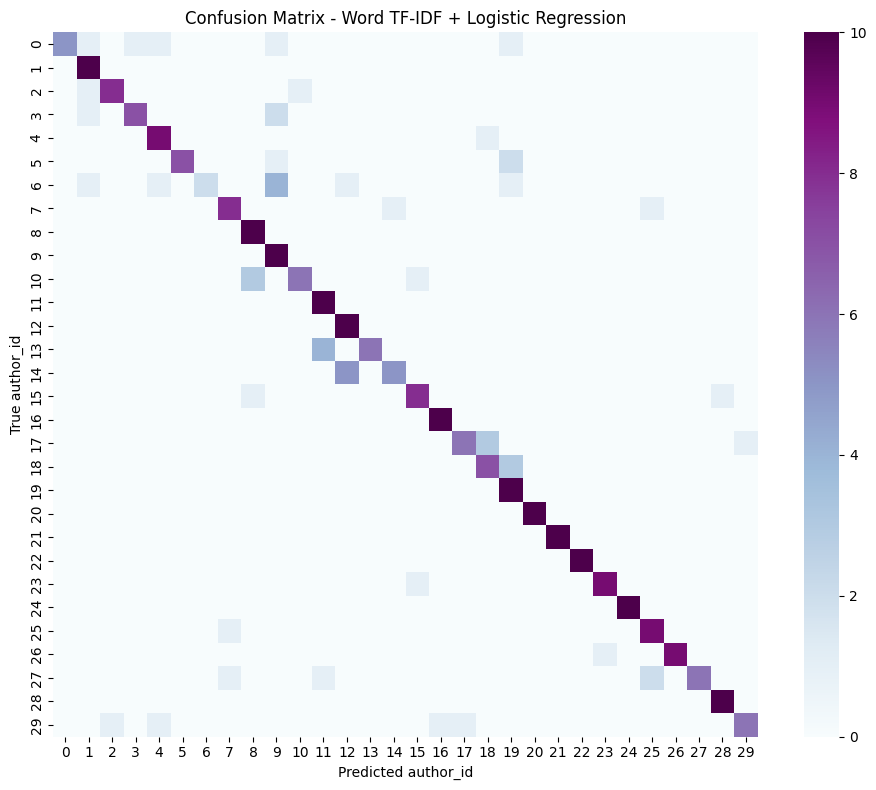

In [48]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="BuPu",   # BuPu isi haritasi renk degeri onemli bir sey degil
    square=True,
)

# plt matplotlibden urettik
plt.xlabel("Predicted author_id")
plt.ylabel("True author_id")
plt.title("Confusion Matrix - Word TF-IDF + Logistic Regression")
plt.tight_layout()
plt.show()


# 9. Most indicative words per author  
We check which n-grams get the highest weights for each author.  
This is basically “what the model thinks defines each author”.


In [49]:

feature_names = vectorizer.get_feature_names_out()



for class_index, author in enumerate(model.classes_):
    coef = model.coef_[class_index]             # o yazara ait ağırlık vektörü (numpy array)
    top_idx = np.argsort(coef)[-5:]             # en büyük 5 ağırlığın index'i
    top_words = feature_names[top_idx]          # bu index'lere denk gelen kelimeler
    print(f"Author {author}: {list(top_words)}") # bu lineda yazarlarin en cok kullandigi kelimeleri yazdiricak


Author 1: ['brown', 'to', 'it', 'and', 'edinburgh']
Author 2: ['labour', 'scottish', 'the', 'the snp', 'snp']
Author 3: ['and', 'scottish', 'of', 'scotland', 'the']
Author 4: ['the snp', 'scotland', 'the', 'scottish', 'snp']
Author 5: ['her', 'she', 'senate', 'obama', 'mccain']
Author 6: ['mr brown', 'per', 'cent', 'per cent', 'mr']
Author 7: ['guardian', 'mp', 'it', 'tory', 'mps']
Author 8: ['manchester', 'league', 'mourinho', 'united', 'football']
Author 9: ['cells', 'said', 'research', 'fat', 'cancer']
Author 10: ['his', 'to', 'he', 'brown', 'the']
Author 11: ['said', 'cancer', 'dementia', 'risk', 'patients']
Author 12: ['gerrard', 'chelsea', 'united', 'league', 'liverpool']
Author 13: ['season', 'series', 'the', 'mets', 'baseball']
Author 14: ['man', 'yuvraj', 'berbatov', 'football', 'his']
Author 15: ['in', 'rodriguez', 'baseball', 'he', 'the']
Author 16: ['children', 'or', 'percent', 'patients', 'dr']
Author 17: ['and', 'the', 'companies', 'of', 'management']
Author 18: ['shares'

# 10. Character-level TF-IDF (3-5 char n-grams)  
PDF also mentions character n-grams.  
Here we train the same model with char-based TF-IDF for comparison.


In [50]:
# Karakter bazlı TF-IDF: 3-5 uzunlukta karakter n-gram'larını kullanıyoruz
vectorizer_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
)

# Train/test metinlerini char-level TF-IDF'e çeviriyoruz
X_train_char = vectorizer_char.fit_transform(X_train)
X_test_char = vectorizer_char.transform(X_test)

# Aynı model türü (Logistic Regression) ile karakter tabanlı sınıflandırma
model_char = LogisticRegression(max_iter=2000)
model_char.fit(X_train_char, y_train)

y_pred_char = model_char.predict(X_test_char)

print(classification_report(y_test, y_pred_char))


              precision    recall  f1-score   support

           1       1.00      0.60      0.75        10
           2       0.80      0.80      0.80        10
           3       0.90      0.90      0.90        10
           4       0.73      0.80      0.76        10
           5       0.69      0.90      0.78        10
           6       1.00      0.80      0.89        10
           7       1.00      0.50      0.67        10
           8       0.73      0.80      0.76        10
           9       0.73      0.80      0.76        10
          10       0.64      0.90      0.75        10
          11       1.00      0.50      0.67        10
          12       0.77      1.00      0.87        10
          13       0.62      1.00      0.77        10
          14       1.00      0.70      0.82        10
          15       0.83      0.50      0.62        10
          16       0.89      0.80      0.84        10
          17       1.00      1.00      1.00        10
          18       1.00    